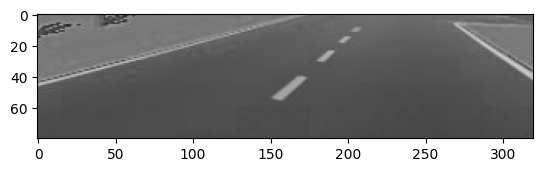

In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

img = cv2.imread("/home/ddon/Downloads/1f41bc05-2292-47a4-8df5-0f8a0fe5d0d0.jpeg")
img = img[-80:, :, 0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

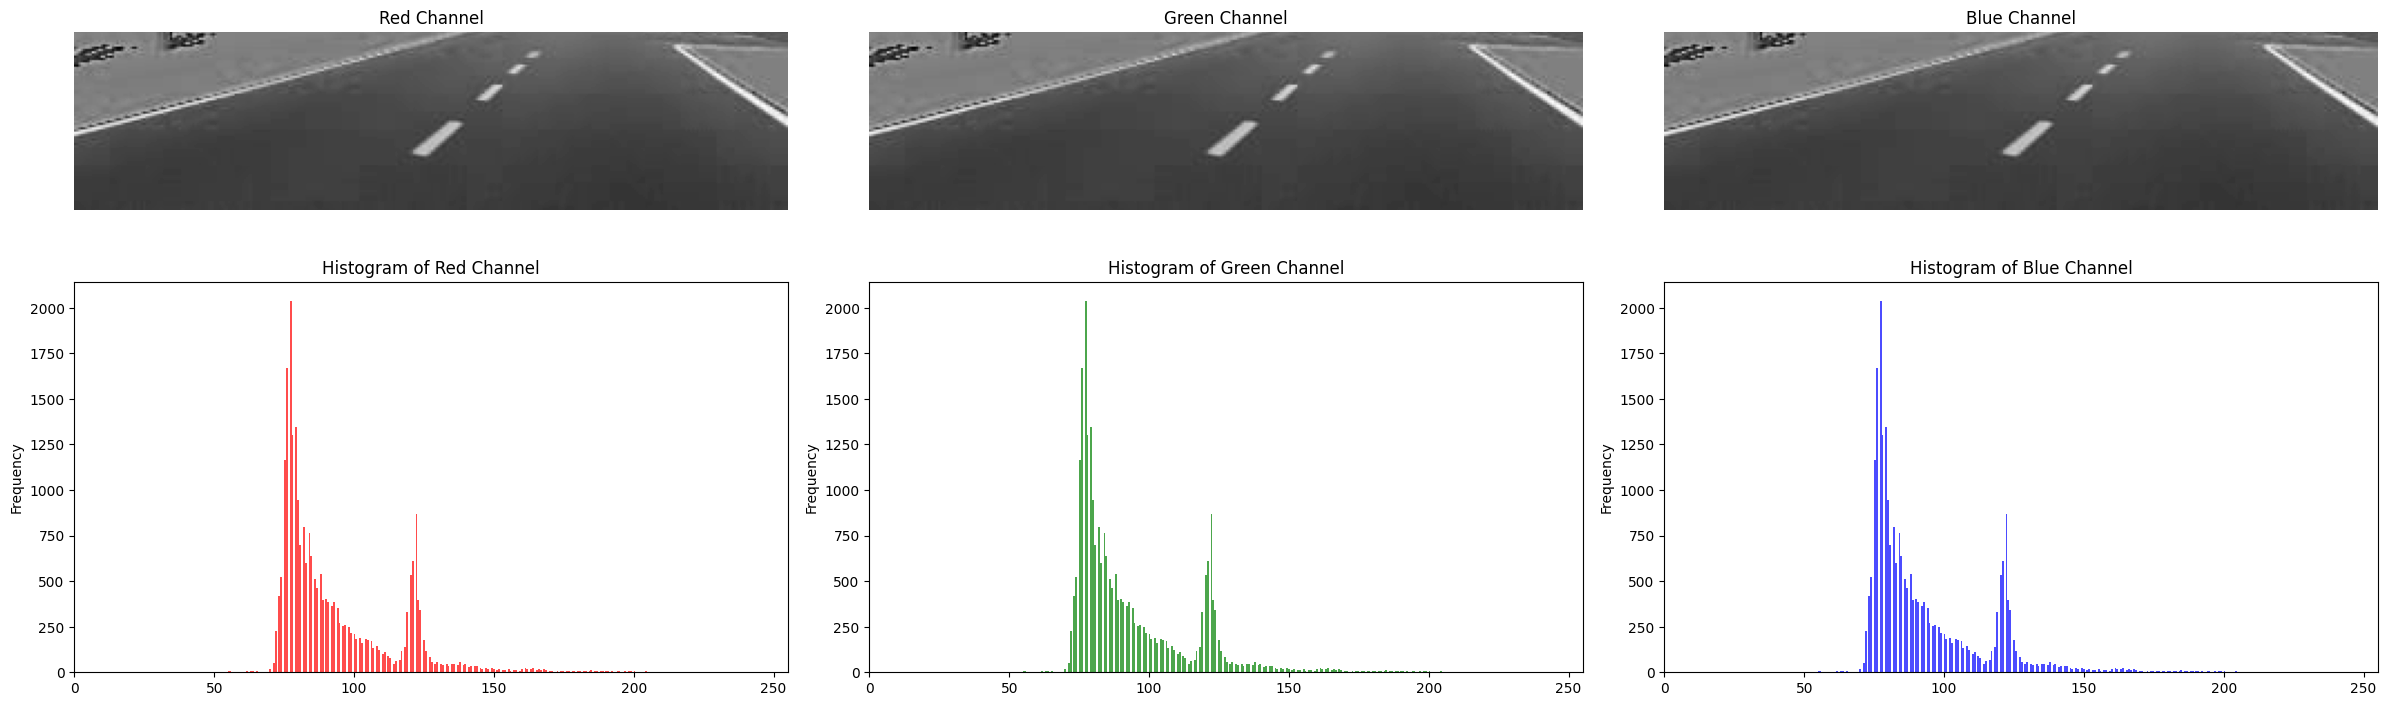

In [22]:
# Create a figure with 3 subplots for images and 3 for histograms
fig, axes = plt.subplots(2, 3, figsize=(24, 8))

# Channel names for labeling
channels = ['Red Channel', 'Green Channel', 'Blue Channel']

# Loop through the channels to display images and histograms
for i in range(3):
    # Display the channel image
    axes[0, i].imshow(img[:, :, i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(channels[i])
    
    # Display the histogram for the channel
    axes[1, i].hist(img[:, :, i].ravel(), bins=256, color=channels[i].lower().split()[0], alpha=0.7)
    axes[1, i].set_xlim([0, 255])  # Adjusted for typical 8-bit image range
    axes[1, i].set_title(f'Histogram of {channels[i]}')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()  # Adjust layout
plt.show()

blue = img[-80:, :, 0]


The value corresponding to 95% cumulative distribution is: 140


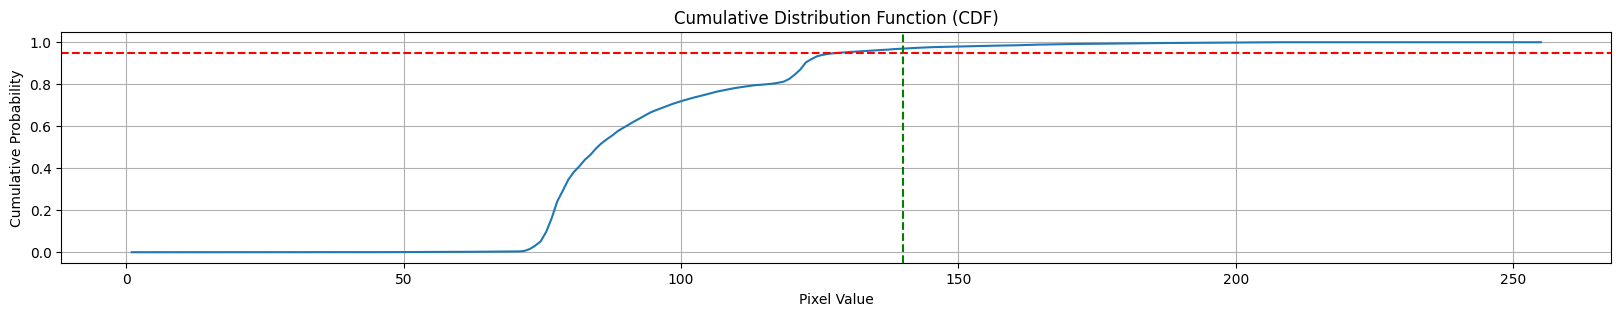

In [23]:
# Flatten the image and compute the histogram
hist, bin_edges = np.histogram(blue.flatten(), bins=256, range=(0, 255))

# Compute the cumulative distribution function (CDF)
cdf = np.cumsum(hist)
cdf_normalized = cdf / cdf[-1]  # Normalize to [0, 1]

# Find the value corresponding to the 90% threshold
threshold_value = np.searchsorted(cdf_normalized, 0.97)

# Print the results
print(f'The value corresponding to 95% cumulative distribution is: {threshold_value}')

# Plotting the CDF
plt.figure(figsize=(20, 3))
plt.plot(bin_edges[1:], cdf_normalized)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=threshold_value, color='g', linestyle='--')
plt.title('Cumulative Distribution Function (CDF)')
plt.xlabel('Pixel Value')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

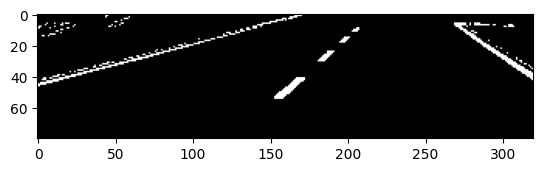

In [24]:
# Set threshold value
threshold = threshold_value  # Adjust as needed

# Create a binary image based on the threshold
binary_blue = np.where(blue > threshold, 255, 0).astype(np.uint8)
plt.imshow(binary_blue, cmap='gray')

Shape of binary image: (80, 320)


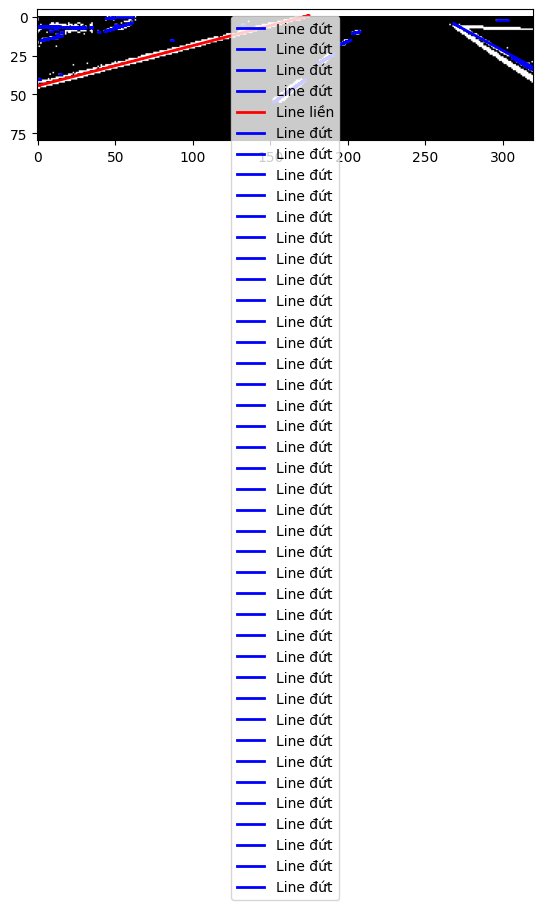

In [25]:
 # Đọc ảnh đã nhị phân hóa
# img = cv2.imread('/mnt/data/image.png', cv2.IMREAD_GRAYSCALE)
# Đọc ảnh gốc (có thể có nhiều kênh)
# img = cv2.imread('/mnt/data/image.png')

# Kiểm tra nếu ảnh đọc thất bại
if img is None:
    raise ValueError("Không thể đọc được ảnh, kiểm tra lại đường dẫn!")

# Chuyển ảnh sang grayscale nếu ảnh không phải dạng đơn kênh
if len(img.shape) > 2:  # Nếu ảnh có nhiều hơn 1 kênh (ví dụ: RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Nhị phân hóa ảnh (ảnh đơn kênh)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Kiểm tra hình dạng của ảnh sau khi chuyển đổi
print(f"Shape of binary image: {binary.shape}")  # Nên là (height, width)

# Tìm các thành phần liên thông trong ảnh nhị phân
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)

# Tạo danh sách chứa thông tin về các line
lines = []

# Phân loại các thành phần liên thông thành line nét liền hoặc nét đứt
for i in range(1, num_labels):  # Bỏ qua nhãn 0 là nền
    area = stats[i, cv2.CC_STAT_AREA]
    
    # Dựa vào kích thước và vị trí để phân loại
    if area > 500:  # Line nét liền (có diện tích lớn)
        lines.append((i, 'liền'))
    else:  # Line nét đứt (diện tích nhỏ hơn)
        lines.append((i, 'đứt'))

# Vẽ ảnh gốc trước khi vẽ các đường hồi quy
plt.imshow(binary, cmap='gray')

# Duyệt qua từng line và áp dụng hồi quy tuyến tính
for label_id, line_type in lines:
    # Lấy các điểm trắng của line hiện tại
    white_points = np.column_stack(np.where(labels == label_id))
    
    if len(white_points) > 0:
        X = white_points[:, 1].reshape(-1, 1)  # Tọa độ x
        y = white_points[:, 0]                 # Tọa độ y

        # Hồi quy tuyến tính cho line hiện tại
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)

        # Vẽ kết quả hồi quy lên ảnh
        color = 'red' if line_type == 'liền' else 'blue'
        plt.plot(X, y_pred, color=color, linewidth=2, label=f'Line {line_type}')

# Hiển thị ảnh với các đường hồi quy
plt.legend()
plt.show()